In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
import os
from scipy.stats import ttest_ind
import json
import lib.galaxy_utilities as gu
from astropy.io import fits
import requests
from lib.python_model_renderer.render_galaxy import _b

In [3]:
# %run make_bulge_bar_dataframes.py

In [4]:
bulge_df = pd.read_pickle('bulge_fractions.pkl').dropna()
bar_df = pd.read_pickle('bar_fractions.pkl').dropna()
bar_length_df = pd.read_pickle('bar_lengths.pkl')
display(bulge_df.head(3))
display(bar_df.head(3))
display(bar_length_df.head(3))

,GZB fraction,GZ2 bulge dominated
subject_id,,
20902000,0.571429,True
20902007,0.937500,True
20902059,0.705882,False


,GZB fraction,GZ2 bar fraction,Strongly barred,No bar
subject_id,,,,
20902000,0.428571,0.736751,True,False
20902007,0.312500,0.072191,False,True
20902059,0.235294,0.212000,False,False


,GZB bar length,GZ2 bar fraction,GZB fraction
subject_id,,,
20902000,NaN,0.736751,0.428571
20902007,NaN,0.072191,0.312500
20902059,75.75,0.212000,0.235294


In [5]:
len(bulge_df), len(bar_df), len(bar_length_df)

(170, 170, 171)

## How frequently do people draw bulges relative to GZ2 pBulge?

In [6]:
gzb_bulge_mean = bulge_df['GZB fraction'].mean()
gzb_bulge_std = bulge_df['GZB fraction'].std()
print('\nGZB bulge fraction = {:.4f} ± {:.5f}\n'.format(
    gzb_bulge_mean, gzb_bulge_std
))
bulge_groups = bulge_df.groupby('GZ2 bulge dominated')
display(pd.DataFrame(
    np.hstack((bulge_groups.mean(), bulge_groups.std())),
    columns=('mean', 'std'),
    index=bulge_groups.mean().index
))

ttest_result = ttest_ind(
    bulge_df[bulge_df['GZ2 bulge dominated']]['GZB fraction'].values,
    bulge_df[~bulge_df['GZ2 bulge dominated']]['GZB fraction'].values
)
print('Probability samples are the same: {:%}'.format(ttest_result.pvalue))


GZB bulge fraction = 0.7480 ± 0.09403



,mean,std
GZ2 bulge dominated,,
False,0.735828,0.087282
True,0.753767,0.096917


Probability samples are the same: 24.569421%


## How frequently do people draw bars relative to GZ2 pBar?

In [7]:
bar_df['type'] = pd.cut(bar_df['GZ2 bar fraction'], (-1, 0.2, 0.5, 2), labels=('No bar', 'Weak bar', 'Strong bar'))
bar_df.groupby('type')['GZB fraction'].describe()

,count,mean,std,min,25%,50%,75%,max
type,,,,,,,,
No bar,76.0,0.279610,0.119497,0.000000,0.198387,0.272222,0.352941,0.705882
Weak bar,56.0,0.374978,0.127934,0.086957,0.294118,0.351471,0.487903,0.588235
Strong bar,38.0,0.465824,0.185284,0.062500,0.301087,0.470175,0.611538,0.823529


In [8]:
print('GZB bar fraction = {:.4f} ± {:.5f}\n'.format(
    bar_df['GZB fraction'].mean(),
    bar_df['GZB fraction'].std()
))

print('P(model has bar | Strongly barred) = {:.4f} ± {:.4f}%'.format(
    bar_df.groupby('Strongly barred')['GZB fraction'].mean().loc[True],
    bar_df.groupby('Strongly barred')['GZB fraction'].std().loc[True],
))

print('P(model has bar | No bar)          = {:.4f} ± {:.4f}%'.format(
    bar_df.groupby('No bar')['GZB fraction'].mean().loc[True],
    bar_df.groupby('No bar')['GZB fraction'].std().loc[True],
))

ttest_result = ttest_ind(
    bar_df[bar_df['Strongly barred']]['GZB fraction'].values,
    bar_df[bar_df['No bar']]['GZB fraction'].values
)
print('\nProbability samples are the same: {:%}'.format(ttest_result.pvalue))

GZB bar fraction = 0.3526 ± 0.15692

P(model has bar | Strongly barred) = 0.4658 ± 0.1853%
P(model has bar | No bar)          = 0.2796 ± 0.1195%

Probability samples are the same: 0.000000%


## How does pbar stack up against aggregate bar length?

Spearman correlation:


,GZB bar length,GZ2 bar fraction,GZB fraction
GZB bar length,1.000000,0.341346,0.073900
GZ2 bar fraction,0.341346,1.000000,0.485514
GZB fraction,0.073900,0.485514,1.000000


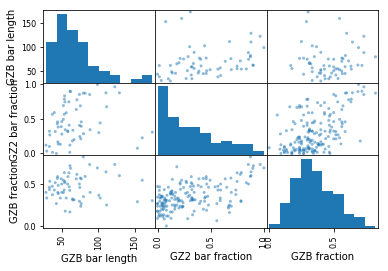

In [9]:
# bar_length_df.plot.scatter(x='GZ2 bar fraction', y='GZB bar length')
print('Spearman correlation:')
display(bar_length_df.corr('spearman'))
pd.plotting.scatter_matrix(bar_length_df);

In [10]:
bar_length_df[bar_length_df['GZB bar length'] > 150]

,GZB bar length,GZ2 bar fraction,GZB fraction
subject_id,,,
20902079,173.969952,0.308534,0.301587
20902080,153.494141,0.076164,0.288889
21096787,160.200000,0.226558,0.545455


# Comparing to photometric fits

Let's load in data from Sandor Kruk's multi-band three-component fits and see what we get:

In [11]:
sandor_bars = pd.read_csv('Kruk2018_Table2_Table3.csv')

We need to convert his SDSS `dr8objid`'s to our `dr8objid`'s

In [12]:
skyserver_url = '/'.join((
    'http://skyserver.sdss.org',
    'dr13', 'en','tools', 'search',
    'x_results.aspx'
))

def get_dr8_id(dr7id_list):
    dr7id_list = json.dumps(dr7id_list).replace('[', '(').replace(']', ')')
    cmd = 'SELECT {} FROM {} WHERE dr7objid IN {}'.format(
        'dr7objid, dr8objid',
        'PhotoObjDR7',
        dr7id_list
    )
    payload = {
        'searchtool': 'SQL',
        'TaskName': 'Skyserver.Search.SQL',
        'syntax': 'NoSyntax',
        'cmd': cmd,
        'format': 'json',
        'TableName': '',
    }
    r = requests.get(
        skyserver_url,
        params=payload,
    )
    try:
        return r.json()[0]['Rows']
    except json.JSONDecodeError:
        print('Could not parse JSON')
        return []

In [13]:
dr7objids = pd.DataFrame(
    list(zip(
        map(
            np.int64,
            (gu.meta_map[subject_id]['SDSS dr7 id']
             for subject_id in bar_length_df.index.values)
        ),
        bar_length_df.index.values
    )),
    columns=('dr7objid', 'subject_id')
)
objid_table = pd.DataFrame(get_dr8_id(dr7objids['dr7objid'].values.tolist()))

dr8objids = pd.DataFrame(
    np.array([
        (dr7objids['subject_id'].iloc[i], j)
        for i in range(len(dr7objids))
        for j in objid_table['dr8objid'][objid_table['dr7objid'] == dr7objids['dr7objid'].iloc[i]]
    ]),
    columns=('subject_id', 'dr8objid')
)

Now to link Sandor's table to a GZB subject id

In [14]:
out = [[0, 0]]
for i, gal in sandor_bars.iterrows():
    m = dr8objids['dr8objid'] == gal['SDSS_dr8objid']
    if np.any(m):
        sids = dr8objids[m]['subject_id'].values
        new = np.stack(
            (sids, np.tile(gal['SDSS_dr8objid'], len(sids))),
            axis=1,
        )
        out = np.concatenate((
            out,
            new
        ))
out = out[1:]

And now link these subject ids to Sandor's classification!

In [15]:
keys = ['Fit_components', 're_disc', 'ba_disc', 're_bar', 'ba_bar', 'ra', 'dec']
sandor_model_info = sandor_bars.set_index(
    'SDSS_dr8objid'
).loc[out[:, 1]]
sandor_model_info['subject_id'] = out[:, 0]
sandor_model_info = sandor_model_info.set_index('subject_id')[keys]
sandor_model_info.head()

,Fit_components,re_disc,ba_disc,re_bar,ba_bar,ra,dec
subject_id,,,,,,,
20902064,disc+bar,17.16,0.84,13.68,0.20,212.05937,16.170189
21686593,disc+bar,17.16,0.84,13.68,0.20,212.05937,16.170189
21686549,disc+bar,43.44,0.75,11.09,0.48,134.34831,17.288004
20902032,disc+bar,36.32,0.63,11.53,0.44,177.03673,12.914601
20901993,disc+bar,25.40,0.68,11.35,0.17,203.03940,-2.749252


In [17]:
gzb_model_info = []
for subject_id in out[:, 0]:
    gal, angle = gu.get_galaxy_and_angle(subject_id)
    size = 4 * gal['PETRO_THETA'].iloc[0] / 0.396
    model_file = 'cluster-output/{}.json'.format(subject_id)
    with open(model_file) as f:
        model = json.load(f)
    components = '+'.join(
        k for k in ('disk', 'bar', 'bulge')
        if model[k] is not None
    )
    if model['disk'] is not None:
        re_disc = max(model['disk']['rx'], model['disk']['ry']) / 3
        ba_disc = model['disk']['rx'] / model['disk']['ry']
        ba_disc = min(ba_disc, 1/ba_disc)
    else:
        re_disc = ba_disc = np.nan
    if model['bar'] is not None:
        re_bar = max(
            model['bar']['width'],
            model['bar']['height']
        ) / 3
        ba_bar = model['bar']['width'] / model['bar']['height']
        ba_bar = min(ba_bar, 1/ba_bar)
    else:
        re_bar = ba_bar = np.nan
    gzb_model_info.append((
        components,
        re_disc * size / 512, ba_disc, 
        re_bar * size / 512, ba_bar,
    ))
gzb_model_info = pd.DataFrame(
    gzb_model_info,
    index=out[:, 0],
    columns=('Fit_components', 're_disc', 'ba_disc', 're_bar', 'ba_bar')
)

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


In [37]:
joined_table = pd.concat((gzb_model_info, sandor_model_info), keys=('Galaxy Builder', 'Photometric'), sort=False).swaplevel().sort_index()
# print(joined_table.round(2).drop(['ra', 'dec'], axis=1).to_latex())
joined_table

Fit_components    re_disc   ba_disc     re_bar  \
20901993 Galaxy Builder  disk+bar+bulge  15.778547  0.675284   7.145691   
         Photometric           disc+bar  25.400000  0.680000  11.350000   
20902000 Galaxy Builder      disk+bulge  21.629254  0.550241        NaN   
         Photometric     disc+bar+bulge  29.710000  0.580000  16.210000   
20902013 Galaxy Builder  disk+bar+bulge  15.580460  0.833240   4.668319   
         Photometric           disc+bar  28.330000  0.890000   7.450000   
20902032 Galaxy Builder      disk+bulge  23.289544  0.566692        NaN   
         Photometric           disc+bar  36.320000  0.630000  11.530000   
20902040 Galaxy Builder  disk+bar+bulge  22.733204  0.649349   9.047600   
         Photometric           disc+bar  38.770000  0.730000   6.910000   
20902049 Galaxy Builder      disk+bulge   8.241175  0.506900        NaN   
         Photometric     disc+bar+bulge  18.660000  0.730000   9.460000   
20902053 Galaxy Builder  disk+bar+bulge   9.817935  0.666519   6.829715   
         Photometric     disc+bar+bulge  16.470000  0.770000   9.340000   
20902057 Galaxy Builder      disk+bulge  10.784768  0.854480        NaN   
         Photometric     disc+bar+bulge  20.310000  0.960000  15.410000   
20902058 Galaxy Builder      disk+bulge  14.678189  0.893318        NaN   
         Photometric     disc+bar+bulge  24.880000  0.940000   5.620000   
20902064 Galaxy Builder  disk+bar+bulge  13.847145  0.632192   7.927658   
         Photometric           disc+bar  17.160000  0.840000  13.680000   
21686510 Galaxy Builder      disk+bulge  18.893711  0.515346        NaN   
         Photometric     disc+bar+bulge  29.710000  0.580000  16.210000   
21686523 Galaxy Builder  disk+bar+bulge  16.600808  0.668796   7.900343   
         Photometric           disc+bar  33.310000  0.760000   9.860000   
21686542 Galaxy Builder  disk+bar+bulge  15.295989  0.870657   6.755886   
         Photometric           disc+bar  28.330000  0.890000   7.450000   
21686549 Galaxy Builder             bar        NaN       NaN   6.556714   
         Photometric           disc+bar  43.440000  0.750000  11.090000   
21686569 Galaxy Builder  disk+bar+bulge  24.522175  0.719763   9.976757   
         Photometric           disc+bar  38.770000  0.730000   6.910000   
21686578 Galaxy Builder           bulge        NaN       NaN        NaN   
         Photometric     disc+bar+bulge  18.660000  0.730000   9.460000   
21686582 Galaxy Builder  disk+bar+bulge  10.173397  0.697928   6.612499   
         Photometric     disc+bar+bulge  16.470000  0.770000   9.340000   
21686587 Galaxy Builder  disk+bar+bulge  15.617053  0.890717   6.076489   
         Photometric     disc+bar+bulge  24.880000  0.940000   5.620000   
21686593 Galaxy Builder  disk+bar+bulge  13.468454  0.615311   9.253816   
         Photometric           disc+bar  17.160000  0.840000  13.680000   

                           ba_bar         ra        dec  
20901993 Galaxy Builder  0.411055        NaN        NaN  
         Photometric     0.170000  203.03940  -2.749252  
20902000 Galaxy Builder       NaN        NaN        NaN  
         Photometric     0.210000  170.44385  25.971556  
20902013 Galaxy Builder  0.386183        NaN        NaN  
         Photometric     0.140000  173.74944  15.685256  
20902032 Galaxy Builder       NaN        NaN        NaN  
         Photometric     0.440000  177.03673  12.914601  
20902040 Galaxy Builder  0.411638        NaN        NaN  
         Photometric     0.200000  135.03293  16.924023  
20902049 Galaxy Builder       NaN        NaN        NaN  
         Photometric     0.350000  139.26723  20.093490  
20902053 Galaxy Builder  0.266330        NaN        NaN  
         Photometric     0.270000  133.37746  20.590601  
20902057 Galaxy Builder       NaN        NaN        NaN  
         Photometric     0.220000  202.57828  32.514446  
20902058 Galaxy Builder       NaN        NaN        NaN  
         Photometric     0.200000  180.69008  39.096268

In [19]:
print('Same components used: {} / {}'.format(
    sum(gzb_model_info['Fit_components'] == [i.replace('disc', 'disk') for i in sandor_model_info['Fit_components'].values]),
    len(gzb_model_info['Fit_components']),
))

Same components used: 3 / 19


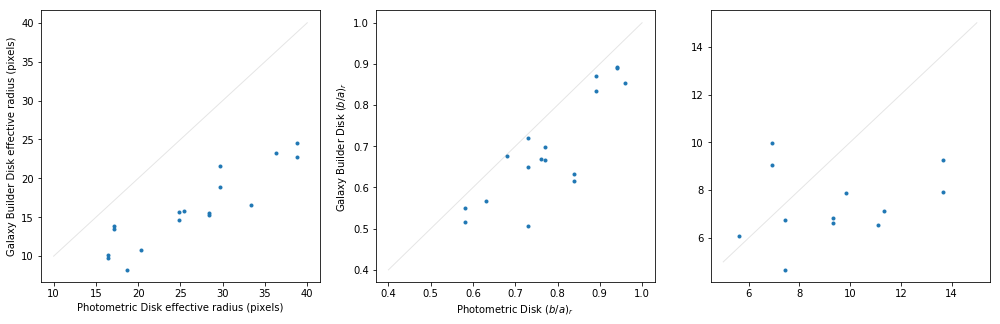

In [20]:
fig, (disk_re, disk_ba, bar_re) = plt.subplots(ncols=3, figsize=(17, 5))

disk_re.plot(sandor_model_info['re_disc'], gzb_model_info['re_disc'], '.')
disk_re.plot(*((10, 40),)*2, 'k', linewidth=1, alpha=0.1)
disk_re.set_xlabel(r'Photometric Disk effective radius (pixels)')
disk_re.set_ylabel(r'Galaxy Builder Disk effective radius (pixels)');

disk_ba.plot(sandor_model_info['ba_disc'], gzb_model_info['ba_disc'], '.')
disk_ba.plot(*((0.4, 1),)*2, 'k', linewidth=1, alpha=0.1)
disk_ba.set_xlabel(r'Photometric Disk $(b/a)_r$')
disk_ba.set_ylabel(r'Galaxy Builder Disk $(b/a)_r$')

bar_re.plot(sandor_model_info['re_bar'], gzb_model_info['re_bar'], '.')
bar_re.plot(*((5, 15),)*2, 'k', linewidth=1, alpha=0.1)

In [21]:
gzb_sandor = pd.DataFrame({
    'subject_id': out[:, 0],
    'sandor_bar_length': sandor_bars.set_index(
        'SDSS_dr8objid'
    ).loc[out[:, 1]]['re_bar'].values,
    'gzb_bar_length': bar_length_df.loc[out[:, 0]]['GZB bar length']
}).set_index('subject_id')

,sandor_bar_length,gzb_bar_length
sandor_bar_length,1.000000,0.867288
gzb_bar_length,0.867288,1.000000


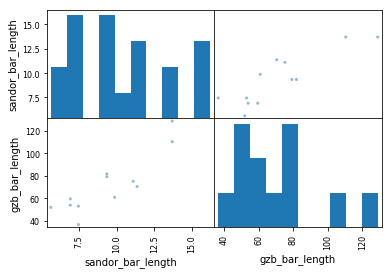

In [22]:
display(gzb_sandor.corr('pearson'))
pd.plotting.scatter_matrix(gzb_sandor);